# Infantile Hemangioma Meta-analysis


> KQ 2: Among newborns, infants, and children up to 18 years of age with infantile hemangiomas who have been referred for pharmacologic intervention, what is the comparative effectiveness (benefits/harms) of corticosteroids or beta-blockers?

Using data extracted by the systematic review, we will conduct a meta-analysis to estimate the effectiveness of several corticosteroids and beta blockers for the treatment of infantile hemangiomas. Of particular interest is the estimation of the efficacy of propranolol, a beta blocker that was used in a large number of studies in the review. To this end, we will determine the expected probability of partial-to-complete clearance for propranolol, and compare this to the same probabilities for several different comparators, as determined by their availability in the dataset.

### Beta-binomial model

For this model, the response variable is the number of individuals in study $j$ under intervention $k$ that achieve the clearance threshold:

$$y_{jk} = \sum_{i=1}^{n_{jk}} = I_i(\text{above clearance threshold})$$

This outcome is modeled as a binomial response:

$$y_{jk} \sim \text{Bin}(n_{jk}, \pi_{jk})$$

where $\pi_{jk})$ is the probability of a positive response for study $j$ under intervention $k$. To allow for heterogeneity in this probability across studies, we can specify it as a random effect:

$$\pi_{jk} \sim \text{Beta}(\alpha, \beta)$$

where $\alpha, \beta$ are the parameters of a beta distribution (which models quantities on the [0,1] interval), resulting in a beta-binomial distribution for the outcome.

It may be possible to incorporate covariates to improve the prediction of propranolol effectiveness. In particular, the mode of delivery (oral, intralesional, topical), dose, or the hemangioma location may be predictive of intervention effectiveness. For a vector of such covariates $x$, we can alternatively model $\pi_{jk}$ as a logit-linear function:

$$\text{logit}(\pi_{jk}) = x_j^{\prime}\theta_k + \epsilon_j$$

where $\theta$ is a corresponding vector of regression parameters corresponding to intervention $k$, and $\epsilon_j$ is a study-level random effect to account for the correlation of study arms.

### Latent variable model

However, the use of an arbitrary cutoff value as a threshold of success is an unfortunate and perhaps unsatisfactory modeling choice. There is an inherent loss of information in the dichotomization of continuous variables, and this loss is magnified here by having to discard data from studies that use a different response threshold than the adopted value (*e.g.* 75%). Since the clearance rate is a continuous measure, one can hypothesize a latent, continuous probability distribution that each study reports according to its respective quantiles: 25%, 50%, 75%, etc. If there is sufficient information, one may use a Bayesian approach to attempt to reconstruct this latent distribution, which would allow for more of the available information to be used in the meta-analytic procedure.  

Under some treatment $k$, one can consider a notional *distribution* of hemangioma clearance rates, from no effect (0) to complete clearance (1). As a matter of convenience in any particular study $j$, researchers will have chosen an arbitrary clearance threshold $c_j$, only recording whether a particular subject occupied one side or the other of this threshold. We can characterize the true, latent response distribution by estimating the parameters $\mu_k, \sigma_k$ via the following identity:

$$\pi_{jk} = 1 - I_{c_j}(\mu_k, \sigma_k)$$

where $I_x(a,b)$ is the cumulative distribution function of a logit-transformed normal distribution under parameters $\mu, \sigma$. The resulting probability is the same as specified above, and can be used in the same binomial likelihood:

$$y_{jk} \sim \text{Bin}(n_{jk}, \pi_{jk})$$

### Comparative effectiveness

Irrespective of which model form is employed, the comparative effectiveness of any two pharmacologic interventions $k=1,2$ can be assessed directly by the difference in their respective clearance threshold probabilities:

$$d_{12} = \pi_1 - \pi_2$$

Using a Bayesian framework, we can extract associated 95% posterior credible intervals for this difference.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sb
import pylab as pl

from scipy.stats import norm

In [2]:
sb.set_style("white")

In [3]:
# Set random number seed
np.random.seed(42)

In [4]:
kq2_outcomes = pd.read_excel('IH_effectiveness_data_Extraction_comparative studies_revised_03242015.xlsx', 
                             sheetname='KQ2_outcome data')

# Individual patient data for RefID 112
kq2_ipd = pd.read_excel('IH_effectiveness_data_Extraction_comparative studies_revised_03242015.xlsx', 
                             sheetname='KQ2_IPD')

Individual patient data for REFID 112 (Qiu 2013). Individual with multiple treatments per lesion was deleted; data from multiple lesions on the same individual were averaged.

In [5]:
unique_outcomes = kq2_outcomes['Outcome'].unique()

In [6]:
unique_interventions = kq2_outcomes['Arm'].unique()

unique_interventions

array(['propranolol', 'atenolol', 'Timolol maleate 0.5% gel', 'placebo',
       'triamcilone', 'prednisolone', 'control', 'control - no treatment',
       'timolol', 'Imiquimod', 'bleomycin', 'prednisone',
       'corticosteroids', 'No treatment - observation', 'triamcinolone',
       'nadolol', 'Methylprednisolone'], dtype=object)

In [7]:
intervention_categories = pd.read_csv('interventions.csv', index_col=0)

Remove unusable interventions

In [8]:
dropped_interventions = intervention_categories[intervention_categories.Label=='DROP'].index.values
kq2_outcomes = kq2_outcomes[~kq2_outcomes.Arm.isin(dropped_interventions)]

Recode interventions into collapsed category set

In [9]:
intervention_lookup = intervention_categories[intervention_categories.Label!='DROP'].to_dict()['Label']

In [10]:
intervention_lookup

{'Control (not treated with propranolol)': 'control',
 'Imiquimod': 'imiquimod',
 'Methylprednisolone': 'methylprednisolone',
 'No treatment - observation': 'control',
 'Timolol maleate 0.5% gel': 'timolol',
 'atenolol': 'atenolol',
 'control': 'control',
 'control - no treatment': 'control',
 'corticosteroids': 'oral steroid',
 'methyprednisolone': 'methylprednisolone',
 'nadolol': 'nadolol',
 'nonpropranolol': 'control',
 'placebo': 'control',
 'prednisolone': 'oral steroid',
 'prednisone': 'oral steroid',
 'propranolol': 'propranolol',
 'timolol': 'timolol',
 'triamcilone': 'triamcilone',
 'triamcilone acetonide': 'triamcilone',
 'triamcinolone': 'triamcilone'}

In [11]:
kq2_outcomes['intervention'] = kq2_outcomes.Arm.replace(intervention_lookup)
kq2_outcomes['intervention'].value_counts()

propranolol           38
timolol               26
control               17
oral steroid          10
triamcilone            9
atenolol               2
imiquimod              1
methylprednisolone     1
nadolol                1
dtype: int64

In [12]:
kq2_outcomes = kq2_outcomes[kq2_outcomes.intervention.isin(['propranolol', 'control', 'timolol', 'triamcilone', 'oral steroid'])]

In [13]:
unique_interventions = kq2_outcomes.intervention.unique()
n_interventions = len(unique_interventions) - 1
n_interventions

4

In [14]:
unique_interventions

array(['propranolol', 'timolol', 'control', 'triamcilone', 'oral steroid'], dtype=object)

Define indices to intervention elements

In [15]:
PROPRANOLOL = 0
TIMOLOL = 1
TRIAMCINOLONE = 2
ORAL_STEROID = 3

Number of unique studies

In [16]:
unique_studies = kq2_outcomes.REFID.unique()
n_studies = len(unique_studies)
n_studies

21

In [17]:
unique_studies

array([   5,  110, 1263,   43,   13,  445, 3740,   72,  112,  309,  321,
        402,  438, 3451, 3522, 3723, 1180, 3875, 3843, 4000, 4007])

In [166]:
POOR, FAIR, GOOD = 0, 1, 2
quality_scores = dict(zip(unique_studies, [FAIR, GOOD, FAIR, FAIR, GOOD, FAIR, POOR, FAIR, FAIR, FAIR, GOOD, GOOD, POOR, POOR, 
                         FAIR, POOR, GOOD, FAIR, FAIR, FAIR, POOR]))

quality_scores

{5: 1,
 13: 2,
 43: 1,
 72: 1,
 110: 2,
 112: 1,
 309: 1,
 321: 2,
 402: 2,
 438: 0,
 445: 1,
 1180: 2,
 1263: 1,
 3451: 0,
 3522: 1,
 3723: 0,
 3740: 0,
 3843: 1,
 3875: 1,
 4000: 1,
 4007: 0}

In [18]:
kq2_outcomes.groupby('REFID')['intervention'].value_counts()

REFID              
5      propranolol      2
13     propranolol      1
       oral steroid     1
43     propranolol     12
72     propranolol      3
       control          3
110    timolol          1
       control          1
112    timolol          1
309    propranolol      4
321    timolol          3
       control          3
402    propranolol      1
       oral steroid     1
438    propranolol      2
       oral steroid     2
445    propranolol      1
       control          1
1180   oral steroid     1
1263   triamcilone      3
       oral steroid     3
       control          3
3451   timolol          4
       control          3
3522   propranolol      6
       triamcilone      6
3723   propranolol      1
3740   propranolol      1
       control          1
3843   propranolol      2
       oral steroid     2
3875   propranolol      2
       control          2
4000   timolol         11
4007   timolol          6
dtype: int64

There does not appear to be sufficient variation in dosage to estimate its effect for any agent.

In [19]:
kq2_outcomes.groupby(['Dosage form','Dosage amount','intervention'])['Dosage'].value_counts()

Dosage form    Dosage amount  intervention          
intralesional  mg/kg          triamcilone   1 to 5       3
               mg/ml          propranolol   1           10
                              triamcilone   40           6
oral           mg/kg          oral steroid  2            5
                                            1-4          2
                                            4            2
                                            2.8          1
                              propranolol   2           17
                                            2-3          2
                                            3 then 4     2
                                            2 to 3       1
                                            3            1
                                            2.7          1
topical        %              timolol       0.5          6
               BID            propranolol   0.01         4
                              timolol       0.0025       3
   

In [20]:
kq2_outcomes.groupby(['intervention', 'Dosage form']).REFID.count()

intervention  Dosage form  
control       none             14
              topical           1
oral steroid  oral             10
propranolol   intralesional    10
              oral             24
              topical           4
timolol       topical          26
triamcilone   intralesional     9
Name: REFID, dtype: int64

## Model specification

Study random effect. Might want to use a robust distribution, like Cauchy or t.

In [21]:
σ_ϵ = pm.Uniform('σ_ϵ', 0, 1000, value=10)
τ_ϵ = σ_ϵ ** -2

ϵ = pm.Normal('ϵ', 0, τ_ϵ, value=np.zeros(n_studies))

Parameters for each intervention

In [22]:
μ = pm.Normal('μ', 0, 0.001, value=-2)
θ = pm.Normal('θ', 0, 0.001, value=np.zeros(n_interventions))
λ = pm.Exponential('λ', 0.1, value=0.5)
σ = pm.HalfNormal('σ', λ, value=np.ones(n_interventions+1))
τ = σ ** -2

In [23]:
θ.value.shape

(4,)

In [24]:
σ.value.shape

(5,)

Alternate mode of delivery effects for propranolol (oral is baseline)

In [25]:
ϕ = pm.Normal('ϕ', 0, 0.001, value=0)

Quality score threshold. Studies must have at least this level to be included.

In [167]:
quality_thresh = POOR

### Abarrzua-Araya 2014 (RefID 5)

In [26]:
subset_cols = ['REFID', 'Arm', 'Dosage', 'Dosage amount', 'Dosage form', 'N at follow-up', 'Outcome', 
    'Outcome data/result', 'Outcome data', 'Point estimate', 'sd', 'Lower range', 'Upper range', 'Outcome data/result N']

In [27]:
kq2_outcomes[kq2_outcomes.REFID==5][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
0,5,propranolol,2,mg/kg,oral,10,Complete response,6 (60),range,NaN,NaN,99,100,6
2,5,propranolol,2,mg/kg,oral,10,Partial response,4 (40),range,NaN,NaN,1,99,4


In [28]:
refid5 = np.where(unique_studies==5)[0][0]

In [29]:
if quality_scores[5] >= quality_thresh:
    
    @pm.deterministic
    def mu_propranolol_5(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for propranolol in RefID 5
        return μ + θ[PROPRANOLOL] + ϵ[refid5]


    @pm.deterministic
    def p_propranolol_5(μ=mu_propranolol_5, τ=τ):
        # Response category probabilities for propranolol in RefID 5
        c1 = norm.cdf(pm.logit(0.01), μ, τ[PROPRANOLOL]**-1)
        c2 = norm.cdf(pm.logit(0.99), μ, τ[PROPRANOLOL]**-1)
        return c1, c2-c1, 1-c2   

    # Multinomial likelihood for propranolol in RefID 5
    y_propranolol_5 = pm.Multinomial('y_propranolol_5', 10, p_propranolol_5, value=[0, 4, 6], observed=True)

### Chan 2013 (RefID 110)

In [30]:
kq2_outcomes[kq2_outcomes.REFID==110][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
4,110,Timolol maleate 0.5% gel,1,Drop,topical,15,Volume reduced by ≥ 5%,60,range,NaN,NaN,5,100,9
5,110,placebo,1,Drop,topical,18,Volume reduced by ≥ 5%,11,range,NaN,NaN,5,100,2


In [31]:
refid110 = np.where(unique_studies==110)[0][0]

In [32]:
if quality_scores[110] >= quality_thresh:

    @pm.deterministic
    def mu_timolol_110(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for timolol in RefID 110
        return μ + θ[TIMOLOL] + ϵ[refid110]


    @pm.deterministic
    def p_timolol_110(μ=mu_timolol_110, τ=τ):
        # Response category probabilities for timolol in RefID 110
        return 1 - norm.cdf(pm.logit(0.05), μ, τ[TIMOLOL]**-1)

    # Binomial likelihood for propranolol in RefID 5
    y_timolol_110 = pm.Binomial('y_timolol_110', 15, p_timolol_110, value=9, observed=True)

In [33]:
if quality_scores[110] >= quality_thresh:


    @pm.deterministic
    def mu_control_110(μ=μ, ϵ=ϵ):
        # Mean response on the logit scale for control in RefID 110
        return μ + ϵ[refid110]


    @pm.deterministic
    def p_control_110(μ=mu_control_110, τ=τ):
        # Response category probabilities for control in RefID 110
        return 1 - norm.cdf(pm.logit(0.05), μ, τ[-1]**-1)

    # Binomial likelihood for control in RefID 5
    y_control_110 = pm.Binomial('y_control_110', 18, p_control_110, value=2, observed=True)

### Jalil 2006 (RefID 1263)

In [34]:
kq2_outcomes[kq2_outcomes.REFID==1263][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
6,1263,triamcilone,1 to 5,mg/kg,intralesional,25,Lesion size reduction > 50%,11 (44),range,NaN,NaN,50,100,11
7,1263,prednisolone,2,mg/kg,oral,25,Lesion size reduction > 50%,8 (32),range,NaN,NaN,50,100,8
8,1263,control,no treatment,NaN,none,25,Lesion size reduction > 50%,0,range,NaN,NaN,50,100,0
9,1263,triamcilone,1 to 5,mg/kg,intralesional,25,Lesion size reduction < 50%,8 (32),range,NaN,NaN,10,50,8
10,1263,prednisolone,2,mg/kg,oral,25,Lesion size reduction < 50%,11 (44),range,NaN,NaN,10,50,11
11,1263,control,no treatment,NaN,none,25,Lesion size reduction < 50%,1 (4),range,NaN,NaN,10,50,1
12,1263,triamcilone,1 to 5,mg/kg,intralesional,25,Lesion size reduction little or none,6 (24),range,NaN,NaN,0,10,6
13,1263,prednisolone,2,mg/kg,oral,25,Lesion size reduction little or none,6 (24),range,NaN,NaN,0,10,6
14,1263,control,no treatment,NaN,none,25,Lesion size reduction little or none,19 (76),range,NaN,NaN,0,10,19


In [35]:
refid1263 = np.where(unique_studies==1263)[0][0]

In [36]:
if quality_scores[1263] >= quality_thresh:

    @pm.deterministic
    def mu_triamcinolone_1263(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for triamcinolone in RefID 1263
        return μ + θ[TRIAMCINOLONE] + ϵ[refid1263]


    @pm.deterministic
    def p_triamcinolone_1263(μ=mu_triamcinolone_1263, τ=τ):
        # Response category probabilities for triamcinolone in RefID 1263
        c1 = norm.cdf(pm.logit(0.1), μ, τ[TRIAMCINOLONE]**-1)
        c2 = norm.cdf(pm.logit(0.5), μ, τ[TRIAMCINOLONE]**-1)
        return c1, c2-c1, 1-c2   

    # Multinomial likelihood for triamcinolone in RefID 1263
    y_triamcinolone_1263 = pm.Multinomial('y_triamcilone_1263', 25, p_triamcinolone_1263, value=[6, 8, 11], observed=True)

In [37]:
if quality_scores[1263] >= quality_thresh:

    @pm.deterministic
    def mu_prednisolone_1263(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for prednisolone in RefID 1263
        return μ + θ[ORAL_STEROID] + ϵ[refid1263]


    @pm.deterministic
    def p_prednisolone_1263(μ=mu_prednisolone_1263, τ=τ):
        # Response category probabilities for prednisolone in RefID 1263
        c1 = norm.cdf(pm.logit(0.1), μ, τ[ORAL_STEROID]**-1)
        c2 = norm.cdf(pm.logit(0.5), μ, τ[ORAL_STEROID]**-1)
        return c1, c2-c1, 1-c2   

    # Multinomial likelihood for prednisolone in RefID 1263
    y_prednisolone_1263 = pm.Multinomial('y_prednisolone_1263', 25, p_prednisolone_1263, value=[6, 11, 8], observed=True)

In [38]:
if quality_scores[1263] >= quality_thresh:

    @pm.deterministic
    def mu_control_1263(μ=μ, ϵ=ϵ):
        # Mean response on the logit scale for control in RefID 1263
        return μ + ϵ[refid1263]


    @pm.deterministic
    def p_control_1263(μ=mu_control_1263, τ=τ):
        # Response category probabilities for prednisolone in RefID 1263
        c1 = norm.cdf(pm.logit(0.01), μ, τ[-1]**-1)
        c2 = norm.cdf(pm.logit(0.1), μ, τ[-1]**-1)
        c3 = norm.cdf(pm.logit(0.5), μ, τ[-1]**-1)
        return c1, c2-c1, c3-c2, 1-c3 

    # Multinomial likelihood for control in RefID 1263
    y_control_1263 = pm.Multinomial('y_control_1263', 25, p_control_1263, value=[5, 19, 1, 0], observed=True)

### Zahar 2013 (RefID 43)

In [39]:
kq2_outcomes[kq2_outcomes.REFID==43][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
15,43,propranolol,2,mg/kg,oral,15,Excellent response (complete resolution),9 (60),range,NaN,NaN,99,100,9
16,43,propranolol,0.01,BID,topical,15,Excellent response (complete resolution),3 (20),range,NaN,NaN,99,100,3
17,43,propranolol,1,mg/ml,intralesional,15,Excellent response (complete resolution),2 (13.3),range,NaN,NaN,99,100,2
18,43,propranolol,2,mg/kg,oral,15,Good response (≥50% reduction in size of IH),2 (13.3),range,NaN,NaN,50,99,2
19,43,propranolol,0.01,BID,topical,15,Good response (≥50% reduction in size of IH),5 (33.3),range,NaN,NaN,50,99,5
20,43,propranolol,1,mg/ml,intralesional,15,Good response (≥50% reduction in size of IH),3 (20),range,NaN,NaN,50,99,3
21,43,propranolol,2,mg/kg,oral,15,Fair response (<50% reduction in size of IH),1 (6.7),range,NaN,NaN,1,50,1
22,43,propranolol,0.01,BID,topical,15,Fair response (<50% reduction in size of IH),2 (13.3),range,NaN,NaN,1,50,2
23,43,propranolol,1,mg/ml,intralesional,15,Fair response (<50% reduction in size of IH),3 (20),range,NaN,NaN,1,50,3
24,43,propranolol,2,mg/kg,oral,15,"Poor response (no response, worsening of IH)",3 (20),scalar,NaN,NaN,0,1,3


In [40]:
refid43 = np.where(unique_studies==43)[0][0]

In [41]:
if quality_scores[43] >= quality_thresh:

    @pm.deterministic
    def mu_propranolol_oral_43(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for oral propranolol in RefID 43
        return μ + θ[PROPRANOLOL] + ϵ[refid43]

    @pm.deterministic
    def mu_propranolol_oral_43(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for oral propranolol in RefID 43
        return μ + θ[PROPRANOLOL] + ϵ[refid43]
    @pm.deterministic
    def p_propranolol_oral_43(μ=mu_propranolol_oral_43, τ=τ):
        # Response category probabilities for oral propranolol in RefID 43
        c1 = norm.cdf(pm.logit(0.01), μ, τ[PROPRANOLOL]**-1)
        c2 = norm.cdf(pm.logit(0.50), μ, τ[PROPRANOLOL]**-1)
        c3 = norm.cdf(pm.logit(0.99), μ, τ[PROPRANOLOL]**-1)
        return c1, c2-c1, c3-c2, 1-c3  

    # Multinomial likelihood for oral propranolol in RefID 43
    y_propranolol_oral_43 = pm.Multinomial('y_propranolol_oral_43', 15, p_propranolol_oral_43, value=[3, 1, 2, 9], 
                                          observed=True)

In [42]:
if quality_scores[43] >= quality_thresh:

    @pm.deterministic
    def mu_propranolol_intralesional_43(μ=μ, θ=θ, ϕ=ϕ, ϵ=ϵ):
        # Mean response on the logit scale for intralesional propranolol in RefID 43
        return μ + θ[PROPRANOLOL] + ϕ + ϵ[refid43]


    @pm.deterministic
    def p_propranolol_intralesional_43(μ=mu_propranolol_intralesional_43, τ=τ):
        # Response category probabilities for intralesional propranolol in RefID 43
        c1 = norm.cdf(pm.logit(0.01), μ, τ[PROPRANOLOL]**-1)
        c2 = norm.cdf(pm.logit(0.50), μ, τ[PROPRANOLOL]**-1)
        c3 = norm.cdf(pm.logit(0.99), μ, τ[PROPRANOLOL]**-1)
        return c1, c2-c1, c3-c2, 1-c3  

    # Multinomial likelihood for intralesional propranolol in RefID 43
    y_propranolol_intralesional_43 = pm.Multinomial('y_propranolol_intralesional_43', 15, p_propranolol_intralesional_43, 
                                                   value=[7, 3, 3, 2], observed=True)

### Bauman 2014 (RefID 13)

This data was given as a mean change on TSA, with 95% confidence interval. We will use a normal factor potential on augmented data based on the estimated mean, and the back-calculated standard deviation.

In [43]:
kq2_outcomes[kq2_outcomes.REFID==13][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
27,13,propranolol,2,mg/kg,oral,9,"Change in TSA, square millimeters",0.64 [0.44-0.83],estimate,0.64,Back calculate,NaN,NaN,NaN
28,13,prednisolone,2,mg/kg,oral,6,"Change in TSA, square millimeters",0.41 [0.10-0.72],estimate,0.41,Back calculate,NaN,NaN,NaN


In [44]:
refid13 = np.where(unique_studies==13)[0][0]

In [45]:
_propranolol_sd = 9 * (0.83 - 0.44) / 3.92
_prednisolone_sd = 6 * (0.72 - 0.10) / 3.92

In [46]:
propranolol_13_var = (_propranolol_sd**2) / (0.64 * (1-0.64))**2
prednisolone_13_var = (_prednisolone_sd**2) / (0.41 * (1-0.41))**2

In [47]:
if quality_scores[13] >= quality_thresh:

    @pm.deterministic
    def mu_propranolol_13(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for oral propranolol in RefID 13
        return μ + θ[PROPRANOLOL] + ϵ[refid13]

    propranolol_obs_13 = pm.Normal('propranolol_obs_13', mu_propranolol_13, propranolol_13_var**-1, 
                                   value=pm.logit(0.64), observed=True)
    
    @pm.deterministic
    def mu_prednisolone_13(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for prednisolone in RefID 43
        return μ + θ[ORAL_STEROID] + ϵ[refid13]

    prednisolone_obs_13 = pm.Normal('prednisolone_obs_13', mu_prednisolone_13, prednisolone_13_var**-1, 
                                    value=pm.logit(0.41), observed=True)

### Hogeling 2011 (RefID 445)

In [49]:
kq2_outcomes[kq2_outcomes.REFID==445][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
29,445,propranolol,2,mg/kg,oral,18,Change in volume,-60,estimate,0.600,NaN,NaN,NaN,18
30,445,placebo,NaN,NaN,none,15,Change in volume,-14.1,estimate,0.147,NaN,NaN,NaN,15


Hogeling et al did not report a measure of uncertainty with the effect sizes, therefore this study must be excluded from the meta-analysis.

### Leaute-Labreze 2015 (RefID 3740)

In [50]:
kq2_outcomes[kq2_outcomes.REFID==3740][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
31,3740,propranolol,3,mg/kg,oral,101,Complete or nearly complete resolution,61 (60),range,NaN,NaN,90,100,61
32,3740,placebo,NaN,NaN,none,25,Complete or nearly complete resolution,2 (4),range,NaN,NaN,90,100,2


In [51]:
refid3740 = np.where(unique_studies==3740)[0][0]

In [52]:
if quality_scores[3740] >= quality_thresh:

    @pm.deterministic
    def mu_propranolol_3740(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for propranolol in RefID 3740
        return μ + θ[PROPRANOLOL] + ϵ[refid3740]


    @pm.deterministic
    def p_propranolol_3740(μ=mu_propranolol_3740, τ=τ):
        # Response category probabilities for propranolol in RefID 3740
        return 1 - norm.cdf(pm.logit(0.9), μ, τ[PROPRANOLOL]**-1)

    # Binomial likelihood for propranolol in RefID 5
    y_propranolol_3740 = pm.Binomial('y_propranolol_3740', 101, p_propranolol_3740, value=61, 
                                    observed=True)

In [53]:
if quality_scores[3740] >= quality_thresh:

    @pm.deterministic
    def mu_control_3740(μ=μ, ϵ=ϵ):
        # Mean response on the logit scale for controls in RefID 3740
        return μ + ϵ[refid3740]


    @pm.deterministic
    def p_control_3740(μ=mu_control_3740, τ=τ):
        # Response category probabilities for controls in RefID 3740
        return 1 - norm.cdf(pm.logit(0.9), μ, τ[-1]**-1)

    # Binomial likelihood for propranolol in RefID 5
    y_control_3740 = pm.Binomial('y_control_3740', 25, p_control_3740, value=2, 
                                    observed=True)

### Sondhi 2013 (RefID 72)

The paper claims `n=14` for controls, but only reports 12 outcomes.

In [54]:
kq2_outcomes[kq2_outcomes.REFID==72][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
33,72,propranolol,2,mg/kg,oral,31,Significant involution (>50%),28,range,NaN,NaN,50,100,28
34,72,propranolol,2,mg/kg,oral,31,Some involution (11%-50%),0,range,NaN,NaN,11,50,0
35,72,propranolol,2,mg/kg,oral,31,No involution (≤10%),3,range,NaN,NaN,0,10,3
36,72,control - no treatment,NaN,NaN,none,14,Significant involution (>50%),4,range,NaN,NaN,50,100,4
37,72,control - no treatment,NaN,NaN,none,14,Some involution (11%-50%),2,range,NaN,NaN,11,50,2
38,72,control - no treatment,NaN,NaN,none,14,No involution (≤10%),6,range,NaN,NaN,0,10,6


In [55]:
refid72 = np.where(unique_studies==72)[0][0]

In [56]:
if quality_scores[72] >= quality_thresh:

    @pm.deterministic
    def mu_propranolol_72(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for propranolol in RefID 72
        return μ + θ[PROPRANOLOL] + ϵ[refid72]


    @pm.deterministic
    def p_propranolol_72(μ=mu_propranolol_72, τ=τ):
        # Response category probabilities for propranolol in RefID 72
        c1 = norm.cdf(pm.logit(0.1), μ, τ[PROPRANOLOL]**-1)
        c2 = norm.cdf(pm.logit(0.5), μ, τ[PROPRANOLOL]**-1)
        return c1, c2-c1, 1-c2   

    # Multinomial likelihood for propranolol in RefID 5
    y_propranolol_72 = pm.Multinomial('y_propranolol_72', 31, p_propranolol_72, value=[3, 0, 28], 
                                    observed=True)

In [57]:
if quality_scores[72] >= quality_thresh:

    @pm.deterministic
    def mu_control_72(μ=μ, ϵ=ϵ):
        # Mean response on the logit scale for controls in RefID 72
        return μ + ϵ[refid72]


    @pm.deterministic
    def p_control_72(μ=mu_control_72, τ=τ):
        # Response category probabilities for controls in RefID 72
        c1 = norm.cdf(pm.logit(0.1), μ, τ[PROPRANOLOL]**-1)
        c2 = norm.cdf(pm.logit(0.5), μ, τ[PROPRANOLOL]**-1)
        return c1, c2-c1, 1-c2   

    # Multinomial likelihood for propranolol in RefID 5
    y_control_72 = pm.Multinomial('y_control_72', 12, p_control_72, value=[6, 2, 4], 
                                    observed=True)

### Qiu 2013 (RefID 112)

Qiu et al. report individual patient data, which we incorporate directly into the meta-analysis.

In [58]:
kq2_outcomes[kq2_outcomes.REFID==112][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
39,112,timolol,0.005,NaN,topical,20,Visual analog scale,NR,IPD,NaN,NaN,NaN,NaN,NR


In [59]:
refid112 = np.where(unique_studies==112)[0][0]

In [60]:
obs_timolol_112 = kq2_ipd[kq2_ipd.Arm=='timolol'].Outcome.values/100.

In [61]:
if quality_scores[112] >= quality_thresh:

    @pm.deterministic
    def mu_timolol_112(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for timolol in RefID 112
        return μ + θ[TIMOLOL] + ϵ[refid112]


    y_timolol_112 = pm.Normal('y_timolol_112', mu_timolol_112, τ[TIMOLOL]**-1, 
                             value=pm.logit(obs_timolol_112 - 1e-6), observed=True)


### Thayal 2012 (RefID 309)

In [62]:
kq2_outcomes[kq2_outcomes.REFID==309][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
44,309,propranolol,2,mg/kg,oral,10,Complete involution (> 90% response),2,range,NaN,NaN,90,100,2
45,309,propranolol,2,mg/kg,oral,10,reduction in size of 75-90 %,4,range,NaN,NaN,75,90,4
46,309,propranolol,2,mg/kg,oral,10,reduction in size of 50 to 75 %,3,range,NaN,NaN,50,75,3
47,309,propranolol,2,mg/kg,oral,10,reduction in size of <25 %,1,range,NaN,NaN,0,25,1


In [63]:
refid309 = np.where(unique_studies==309)[0][0]

In [64]:
if quality_scores[309] >= quality_thresh:

    @pm.deterministic
    def mu_propranolol_309(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for propranolol in RefID 309
        return μ + θ[PROPRANOLOL] + ϵ[refid309]


    @pm.deterministic
    def p_propranolol_309(μ=mu_propranolol_309, τ=τ):
        # Response category probabilities for propranolol in RefID 309
        c1 = norm.cdf(pm.logit(0.25), μ, τ[PROPRANOLOL]**-1)
        c2 = norm.cdf(pm.logit(0.5), μ, τ[PROPRANOLOL]**-1)
        c3 = norm.cdf(pm.logit(0.75), μ, τ[PROPRANOLOL]**-1)
        c4 = norm.cdf(pm.logit(0.9), μ, τ[PROPRANOLOL]**-1)
        return c1, c2-c1, c3-c2, c4-c3, 1-c4  

    # Multinomial likelihood for propranolol in RefID 309
    y_propranolol_309 = pm.Multinomial('y_propranolol_309', 10, p_propranolol_309, 
                                      value=[1, 0, 3, 4, 2], observed=True)

### Chambers 2012 (RefID 321)

In [65]:
kq2_outcomes[kq2_outcomes.REFID==321][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
48,321,timolol,0.0025,BID,topical,13,reduction in size of >50 %,61.5,range,NaN,NaN,50,100,8
49,321,timolol,0.0025,BID,topical,13,reduction in size of 0-50 %,30.8,range,NaN,NaN,1,50,4
50,321,timolol,0.0025,BID,topical,13,enlarged in size,NaN,range,NaN,NaN,0,1,1
51,321,control,NaN,NaN,none,10,reduction in size of >50 %,0,range,NaN,NaN,50,100,0
52,321,control,NaN,NaN,none,10,reduction in size of 0-50 %,10,range,NaN,NaN,1,50,1
53,321,control,NaN,NaN,none,10,enlarged in size,NaN,range,NaN,NaN,0,1,9


In [66]:
refid321 = np.where(unique_studies==321)[0][0]

In [67]:
if quality_scores[321] >= quality_thresh:

    @pm.deterministic
    def mu_timolol_321(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for timolol in RefID 321
        return μ + θ[TIMOLOL] + ϵ[refid321]


    @pm.deterministic
    def p_timolol_321(μ=mu_timolol_321, τ=τ):
        # Response category probabilities for timolol in RefID 321
        c1 = norm.cdf(pm.logit(0.01), μ, τ[TIMOLOL]**-1)
        c2 = norm.cdf(pm.logit(0.5), μ, τ[TIMOLOL]**-1)
        return c1, c2-c1, 1 - c2

    # Binomial likelihood for propranolol in RefID 321
    y_timolol_321 = pm.Multinomial('y_timolol_321', 13, p_timolol_321, value=[1, 4, 8], observed=True)

In [68]:
if quality_scores[321] >= quality_thresh:

    @pm.deterministic
    def mu_control_321(μ=μ, ϵ=ϵ):
        # Mean response on the logit scale for controls in RefID 321
        return μ + ϵ[refid321]


    @pm.deterministic
    def p_control_321(μ=mu_control_321, τ=τ):
        # Response category probabilities for controls in RefID 321
        c1 = norm.cdf(pm.logit(0.01), μ, τ[-1]**-1)
        c2 = norm.cdf(pm.logit(0.5), μ, τ[-1]**-1)
        return c1, c2-c1, 1 - c2

    # Binomial likelihood for controls in RefID 321
    y_control_321 = pm.Multinomial('y_control_321', 10, p_control_321, value=[9, 1, 0], observed=True)

### Bertrand 2011 (RefID 402)

In [69]:
kq2_outcomes[kq2_outcomes.REFID==402][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
54,402,prednisone,2.8,mg/kg,oral,12,Visual Analog Scale - mean mm,44.82,estimate,44.82,12.21,NaN,NaN,NaN
55,402,propranolol,2.7,mg/kg,oral,12,Visual Analog Scale - mean mm,78.73,estimate,78.73,22.47,NaN,NaN,NaN


In [70]:
refid402 = np.where(unique_studies==402)[0][0]

Find SD on the logit scale using the delta method

In [71]:
propranolol_402_var = (0.2247**2) / (0.7873 * (1-0.7873))**2
prednisone_402_var = (0.1221**2) / (0.4482 * (1-0.4482))**2

In [72]:
if quality_scores[402] >= quality_thresh:

    @pm.deterministic
    def mu_propranolol_402(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for oral propranolol in RefID 402
        return μ + θ[PROPRANOLOL] + ϵ[refid402]

    propranolol_obs_402 = pm.Normal('propranolol_obs_402', mu_propranolol_402, propranolol_402_var**-1, 
                                    value=pm.logit(0.7873), observed=True)

    @pm.deterministic
    def mu_prednisolone_402(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for prednisolone in RefID 402
        return μ + θ[ORAL_STEROID] + ϵ[refid402]

    prednisolone_obs_402 = pm.Normal('prednisolone_obs_402', mu_prednisolone_402, prednisone_402_var**-1, 
                                     pm.logit(0.4482), observed=True)

### Price 2011 (RefID 438)

In [74]:
kq2_outcomes[kq2_outcomes.REFID==438][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
56,438,propranolol,2,mg/kg,oral,68,Clearance ≥ 75%,56,range,NaN,NaN,75,100,56
57,438,propranolol,2,mg/kg,oral,68,Clearance <75%,12,range,NaN,NaN,0,75,12
58,438,corticosteroids,4,mg/kg,oral,42,Clearance ≥ 75%,12,range,NaN,NaN,75,100,12
59,438,corticosteroids,4,mg/kg,oral,42,Clearance <75%,30,range,NaN,NaN,0,75,30


In [75]:
refid438 = np.where(unique_studies==438)[0][0]

In [76]:
if quality_scores[438] >= quality_thresh:

    @pm.deterministic
    def mu_propranolol_438(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for propranolol in RefID 438
        return μ + θ[PROPRANOLOL] + ϵ[refid438]


    @pm.deterministic
    def p_propranolol_438(μ=mu_propranolol_438, τ=τ):
        # Response category probabilities for propranolol in RefID 438
        return 1 - norm.cdf(pm.logit(0.75), μ, τ[PROPRANOLOL]**-1)

    # Binomial likelihood for propranolol in RefID 5
    y_propranolol_438 = pm.Binomial('y_propranolol_438', 68, p_propranolol_438, 
                                    value=56, observed=True)

In [77]:
if quality_scores[438] >= quality_thresh:

    @pm.deterministic
    def mu_corticosteriod_438(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for corticosteriods in RefID 438
        return μ + θ[ORAL_STEROID] + ϵ[refid438]


    @pm.deterministic
    def p_corticosteriod_438(μ=mu_corticosteriod_438, τ=τ):
        # Response category probabilities for corticosteriods in RefID 438
        return 1 - norm.cdf(pm.logit(0.75), μ, τ[ORAL_STEROID]**-1)

    # Binomial likelihood for propranolol in RefID 5
    y_corticosteriod_438 = pm.Binomial('y_corticosteriod_438', 42, p_corticosteriod_438, 
                                    value=12, observed=True)

### Yu 2013 (RefID 3451)

In [78]:
kq2_outcomes[kq2_outcomes.REFID==3451][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
60,3451,timolol,NR,NR,topical,101,Response - ineffective,7.9,range,NaN,NaN,0,1,8
61,3451,timolol,NR,NR,topical,101,Response - controlled growth,35.6,range,NaN,NaN,0,1,36
62,3451,timolol,NR,NR,topical,101,Response - promoted regression,56.4,range,NaN,NaN,1,99,57
63,3451,timolol,NR,NR,topical,101,Complete regression,12,range,NaN,NaN,99,100,12
64,3451,No treatment - observation,NaN,NaN,none,23,Response - ineffective,65.2,range,NaN,NaN,0,1,15
65,3451,No treatment - observation,NaN,NaN,none,23,Response - controlled growth,30.4,range,NaN,NaN,0,1,7
66,3451,No treatment - observation,NaN,NaN,none,23,Response - promotedregression,4.3,range,NaN,NaN,1,99,1


In [79]:
refid3451 = np.where(unique_studies==3451)[0][0]

In [80]:
if quality_scores[3451] >= quality_thresh:

    @pm.deterministic
    def mu_timolol_3451(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for timolol in RefID 3451
        return μ + θ[TIMOLOL] + ϵ[refid3451]


    @pm.deterministic
    def p_timolol_3451(μ=mu_timolol_3451, τ=τ):
        # Response category probabilities for timolol in RefID 3451
        c1 = norm.cdf(pm.logit(0.01), μ, τ[TIMOLOL]**-1)
        c2 = norm.cdf(pm.logit(0.99), μ, τ[TIMOLOL]**-1)
        return c1, c2-c1, 1 - c2

    # Binomial likelihood for propranolol in RefID 3451
    y_timolol_3451 = pm.Multinomial('y_timolol_3451', 101, p_timolol_3451, value=[44, 57-12, 12], observed=True)

In [81]:
if quality_scores[3451] >= quality_thresh:

    @pm.deterministic
    def mu_control_3451(μ=μ, ϵ=ϵ):
        # Mean response on the logit scale for controls in RefID 3451
        return μ + ϵ[refid3451]


    @pm.deterministic
    def p_control_3451(μ=mu_control_3451, τ=τ):
        # Response category probabilities for timolol in RefID 3451
        c1 = norm.cdf(pm.logit(0.01), μ, τ[-1]**-1)
        c2 = norm.cdf(pm.logit(0.99), μ, τ[-1]**-1)
        return c1, c2-c1, 1 - c2

    # Binomial likelihood for propranolol in RefID 3451
    y_control_3451 = pm.Multinomial('y_control_3451', 23, p_control_3451, value=[22, 1, 0], observed=True)

### Awadein 2011 (RefID 3522)

In [82]:
kq2_outcomes[kq2_outcomes.REFID==3522][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
67,3522,propranolol,1,mg/ml,intralesional,12,Size of hemangioma (cm2),3.6 ± 2.6,NaN,NaN,NaN,NaN,NaN,NaN
68,3522,propranolol,1,mg/ml,intralesional,12,Response rate - Complete resolution achieved,42,scalar,NaN,NaN,99,100,5
69,3522,propranolol,1,mg/ml,intralesional,12,"Response rate - Sustained plateau, with >50% r...",25,range,NaN,NaN,50,99,3
70,3522,propranolol,1,mg/ml,intralesional,12,Response rate - <50% reduction in size of hema...,17,range,NaN,NaN,0,50,2
71,3522,propranolol,1,mg/ml,intralesional,12,Resistant to treatment,17,NaN,NaN,NaN,NaN,NaN,2
72,3522,propranolol,1,mg/ml,intralesional,12,Rebound growth,4,NaN,NaN,NaN,NaN,NaN,4
73,3522,triamcinolone,40,mg/ml,intralesional,10,Size of hemangioma (cm2),3.7 ± 2.5,NaN,NaN,NaN,NaN,NaN,NaN
74,3522,triamcinolone,40,mg/ml,intralesional,10,Response rate - Complete resolution achieved,40,range,NaN,NaN,99,100,4
75,3522,triamcinolone,40,mg/ml,intralesional,10,"Response rate - Sustained plateau, with >50% r...",20,range,NaN,NaN,50,99,2
76,3522,triamcinolone,40,mg/ml,intralesional,10,Response rate - <50% reduction in size of hema...,20,range,NaN,NaN,0,50,2


In [83]:
refid3522 = np.where(unique_studies==3522)[0][0]

In [84]:
if quality_scores[3522] >= quality_thresh:

    @pm.deterministic
    def mu_propranolol_intralesional_3522(μ=μ, θ=θ, ϕ=ϕ, ϵ=ϵ):
        # Mean response on the logit scale for intralesional propranolol in RefID 3522
        return μ + θ[PROPRANOLOL] + ϕ + ϵ[refid3522]


    @pm.deterministic
    def p_propranolol_intralesional_3522(μ=mu_propranolol_intralesional_3522, τ=τ):
        # Response category probabilities for intralesional propranolol in RefID 3522
        c1 = norm.cdf(pm.logit(0.01), μ, τ[PROPRANOLOL]**-1)
        c2 = norm.cdf(pm.logit(0.50), μ, τ[PROPRANOLOL]**-1)
        c3 = norm.cdf(pm.logit(0.99), μ, τ[PROPRANOLOL]**-1)
        return c1, c2-c1, c3-c2, 1-c3 

    # Multinomial likelihood for intralesional propranolol in RefID 3522
    y_propranolol_intralesional_3522 = pm.Multinomial('y_propranolol_intralesional_3522', 12, 
                                                      p_propranolol_intralesional_3522, 
                                                   value=[2, 2, 3, 5], observed=True)

In [85]:
if quality_scores[3522] >= quality_thresh:

    @pm.deterministic
    def mu_triamcinolone_3522(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for triamcinolone in RefID 3522
        return μ + θ[TRIAMCINOLONE] + ϵ[refid3522]


    @pm.deterministic
    def p_triamcinolone_3522(μ=mu_triamcinolone_3522, τ=τ):
        # Response category probabilities for triamcinolone in RefID 3522
        c1 = norm.cdf(pm.logit(0.01), μ, τ[TRIAMCINOLONE]**-1)
        c2 = norm.cdf(pm.logit(0.50), μ, τ[TRIAMCINOLONE]**-1)
        c3 = norm.cdf(pm.logit(0.99), μ, τ[TRIAMCINOLONE]**-1)
        return c1, c2-c1, c3-c2, 1-c3 

    # Multinomial likelihood for triamcinolone in RefID 3522
    y_triamcinolone_3522 = pm.Multinomial('y_triamcinolone_3522', 10, p_triamcinolone_3522, 
                                                   value=[2, 2, 2, 4], observed=True)

### Pope 2007 (RefID 1180)

In [86]:
kq2_outcomes[kq2_outcomes.REFID==1180][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
82,1180,prednisolone,2,mg/kg,oral,10,Change in size measured using VAS at AGE 1 year,50 (35 to 67),difference,50,NaN,35,67,NaN


In [87]:
refid1180 = np.where(unique_studies==1180)[0][0]

In [88]:
prednisolone_sd_1180 = (0.67 - 0.35) / 1.35

In [89]:
if quality_scores[1180] >= quality_thresh:

    prednisolone_1180_latent = pm.Normal('prednisolone_1180_latent', 0.5, 
                                                 prednisolone_sd_1180**-2, size=10)

    prednisolone_1180_trunc = pm.Lambda('prednisolone_1180_trunc', 
                                             lambda y=prednisolone_1180_latent: np.clip(y, 1e-6, 1-1e-6)).value

In [91]:
if quality_scores[1180] >= quality_thresh:

    @pm.deterministic
    def mu_prednisolone_1180(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for prednisolone in RefID 1180
        return μ + θ[ORAL_STEROID] + ϵ[refid1180]

    @pm.potential
    def prednisolone_obs_1180(μ=mu_prednisolone_1180, τ=τ, y=prednisolone_1180_trunc):
        return pm.normal_like(pm.logit(y), μ, τ[ORAL_STEROID])

### Pope 2012 (RefID 3723)

In [92]:
kq2_outcomes[kq2_outcomes.REFID==3723][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
80,3723,propranolol,2 to 3,mg/kg,oral,9,percentage IH shrinkage,86 ± 14.82,estimate,86,14.82,NaN,NaN,NaN


In [93]:
refid3723 = np.where(unique_studies==3723)[0][0]

In [94]:
propranolol_3723_var = (0.1482**2) / (0.86 * (1-0.86))**2

In [95]:
if quality_scores[3723] >= quality_thresh:

    @pm.deterministic
    def mu_propranolol_3723(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for oral propranolol in RefID 3723
        return μ + θ[PROPRANOLOL] + ϵ[refid3723]

    propranolol_obs_3723 = pm.Normal('propranolol_obs_3723', mu_propranolol_3723, propranolol_3723_var**-1, 
                                    value=pm.logit(0.86), observed=True)

### Leaute-Labreze 2013 (RefID 3875)

In [96]:
kq2_outcomes[kq2_outcomes.REFID==3875][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
83,3875,propranolol,3 then 4,mg/kg,oral,6,change in thickness,"44.9 (36.0, 76.2)",NaN,44.9,NaN,NaN,NaN,NaN
84,3875,propranolol,3 then 4,mg/kg,oral,6,percentage change in size,"15.8 (2.4, 51.7)",NaN,15.8,NaN,NaN,NaN,NaN
85,3875,placebo,NaN,NaN,NaN,6,change in thickness,-11.3,NaN,-11.3,NaN,NaN,NaN,NaN
86,3875,placebo,NaN,NaN,NaN,6,percentage change in size,-8.9,NaN,-8.9,NaN,NaN,NaN,NaN


In [97]:
refid3875 = np.where(unique_studies==3875)[0][0]

In [98]:
_propranolol_3875_sd = 6 * (0.517 - 0.024) / 3.92

In [99]:
propranolol_3875_var = (_propranolol_3875_sd**2) / (0.158 * (1-0.158))**2

In [100]:
if quality_scores[3875] >= quality_thresh:

    @pm.deterministic
    def mu_propranolol_3875(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for oral propranolol in RefID 13
        return μ + θ[PROPRANOLOL] + ϵ[refid3875]

    propranolol_obs_3875 = pm.Normal('propranolol_obs_3875', mu_propranolol_3875, propranolol_3875_var**-1, 
                                   value=pm.logit(0.158), observed=True)

### Malik 2013 (RefID 3843)

In [101]:
kq2_outcomes[kq2_outcomes.REFID==3843][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
87,3843,propranolol,2-3,mg/kg,oral,5,"color fading, flattening",NaN,NaN,NaN,1.7,NaN,NaN,NaN
88,3843,prednisolone,1-4,mg/kg,oral,4,"color fading, flattening",NaN,NaN,NaN,2.9,NaN,NaN,NaN
89,3843,propranolol,2-3,mg/kg,oral,5,mean size reduction,89.8 ± 10.3,NaN,89.8,10.3,NaN,NaN,NaN
90,3843,prednisolone,1-4,mg/kg,oral,4,mean size reduction,66.6 ± 41.6,NaN,66.6,41.6,NaN,NaN,NaN


In [102]:
refid3843 = np.where(unique_studies==3843)[0][0]

In [103]:
propranolol_3843_var = (0.103**2) / (0.898 * (1-0.898))**2
prednisolone_3843_var = (0.416**2) / (0.666 * (1-0.666))**2

In [104]:
if quality_scores[3843] >= quality_thresh:

    @pm.deterministic
    def mu_propranolol_3843(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for oral propranolol in RefID 3843
        return μ + θ[PROPRANOLOL] + ϵ[refid3843]

    propranolol_obs_3843 = pm.Normal('propranolol_obs_3843', mu_propranolol_3843, propranolol_3843_var**-1, 
                                    value=pm.logit(0.898), observed=True)

    @pm.deterministic
    def mu_prednisolone_3843(μ=μ, θ=θ, ϵ=ϵ):
        # Mean response on the logit scale for prednisolone in RefID 3843
        return μ + θ[ORAL_STEROID] + ϵ[refid3843]

    prednisolone_obs_3843 = pm.Normal('prednisolone_obs_3843', mu_prednisolone_3843, prednisolone_3843_var**-1, 
                                    value=pm.logit(0.666), observed=True)

### Tawfik 2015 (RefID 4000)

In [105]:
kq2_outcomes[kq2_outcomes.REFID==4000][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
91,4000,timolol,5,mg/ml,topical,30,No improvement (0 %) in ≤ 6month old,NaN,NaN,NaN,NaN,NaN,NaN,0
92,4000,timolol,5,mg/ml,topical,30,Mild improvement (<25%) in ≤ 6month old,NaN,NaN,NaN,NaN,NaN,NaN,1
93,4000,timolol,5,mg/ml,topical,30,Moderate imrovement (26% - 50%) in ≤ 6month old,NaN,NaN,NaN,NaN,NaN,NaN,1
94,4000,timolol,5,mg/ml,topical,30,Good improvement (51% - 75%) in ≤ 6month old,NaN,NaN,NaN,NaN,NaN,NaN,3
95,4000,timolol,5,mg/ml,topical,30,Excellent improvement (76% 110%) in ≤ 6month old,NaN,NaN,NaN,NaN,NaN,NaN,3
96,4000,timolol,5,mg/ml,topical,30,No improvement (0 %) in > 6month old,NaN,NaN,NaN,NaN,NaN,NaN,4
97,4000,timolol,5,mg/ml,topical,30,Mild improvement (<25%) in > 6month old,NaN,NaN,NaN,NaN,NaN,NaN,3
98,4000,timolol,5,mg/ml,topical,30,Moderate imrovement (26% - 50%) in > 6month old,NaN,NaN,NaN,NaN,NaN,NaN,3
99,4000,timolol,5,mg/ml,topical,30,Good improvement (51% - 75%) in > 6month old,NaN,NaN,NaN,NaN,NaN,NaN,6
100,4000,timolol,5,mg/ml,topical,30,Excellent improvement (76% 110%) in > 6month old,NaN,NaN,NaN,NaN,NaN,NaN,6


In [106]:
refid4000 = np.where(unique_studies==4000)[0][0]

In [107]:
if quality_scores[4000] >= quality_thresh:

    @pm.deterministic
    def mu_timolol_4000(μ=μ, θ=θ, ϕ=ϕ, ϵ=ϵ):
        # Mean response on the logit scale for timolol in RefID 4000
        return μ + θ[TIMOLOL] + ϵ[refid4000]


    @pm.deterministic
    def p_timolol_4000(μ=mu_timolol_4000, τ=τ):
        # Response category probabilities for timolol in RefID 4000
        c1 = norm.cdf(pm.logit(0.01), μ, τ[TIMOLOL]**-1)
        c2 = norm.cdf(pm.logit(0.25), μ, τ[TIMOLOL]**-1)
        c3 = norm.cdf(pm.logit(0.50), μ, τ[TIMOLOL]**-1)
        c4 = norm.cdf(pm.logit(0.75), μ, τ[TIMOLOL]**-1)
        return c1, c2-c1, c3-c2, c4-c3, 1-c4

    # Multinomial likelihood for timolol in RefID 4007
    y_timolol_4000 = pm.Multinomial('y_timolol_4000', 30, 
                                                  p_timolol_4000, 
                                                  value=[4, 4, 4, 9, 9], observed=True)

### Park 2014 (RefID 4007)

In [108]:
kq2_outcomes[kq2_outcomes.REFID==4007][subset_cols]

,REFID,Arm,Dosage,Dosage amount,Dosage form,N at follow-up,Outcome,Outcome data/result,Outcome data,Point estimate,sd,Lower range,Upper range,Outcome data/result N
102,4007,timolol,0.5,%,topical,61,Improvement < 0,NaN,NaN,NaN,NaN,NaN,NaN,0
103,4007,timolol,0.5,%,topical,61,Improvement = 0,NaN,NaN,NaN,NaN,NaN,NaN,3
104,4007,timolol,0.5,%,topical,61,Improvement = 0 - 24,NaN,NaN,NaN,NaN,NaN,NaN,19
105,4007,timolol,0.5,%,topical,61,Improvement = 25 - 49,NaN,NaN,NaN,NaN,NaN,NaN,11
106,4007,timolol,0.5,%,topical,61,Improvement = 50 - 74,NaN,NaN,NaN,NaN,NaN,NaN,14
107,4007,timolol,0.5,%,topical,61,Improvement = 75 - 100,NaN,NaN,NaN,NaN,NaN,NaN,14


In [109]:
refid4007 = np.where(unique_studies==4007)[0][0]

In [110]:
if quality_scores[4007] >= quality_thresh:

    @pm.deterministic
    def mu_timolol_4007(μ=μ, θ=θ, ϕ=ϕ, ϵ=ϵ):
        # Mean response on the logit scale for timolol in RefID 4007
        return μ + θ[TIMOLOL] + ϵ[refid4007]


    @pm.deterministic
    def p_timolol_4007(μ=mu_timolol_4007, τ=τ):
        # Response category probabilities for timolol in RefID 4007
        c1 = norm.cdf(pm.logit(0.01), μ, τ[TIMOLOL]**-1)
        c2 = norm.cdf(pm.logit(0.25), μ, τ[TIMOLOL]**-1)
        c3 = norm.cdf(pm.logit(0.50), μ, τ[TIMOLOL]**-1)
        c4 = norm.cdf(pm.logit(0.75), μ, τ[TIMOLOL]**-1)
        return c1, c2-c1, c3-c2, c4-c3, 1-c4

    # Multinomial likelihood for timolol in RefID 4007
    y_timolol_4007 = pm.Multinomial('y_timolol_4007', 61, 
                                                  p_timolol_4007, 
                                                  value=[3, 19, 11, 14, 14], observed=True)

Expected clearance rates for each treatment

In [111]:
@pm.deterministic
def expected_clearance(μ=μ, θ=θ, ϕ=ϕ):
    p = np.append(pm.invlogit(μ), pm.invlogit(μ + θ[0] + ϕ))
    return np.append(p, pm.invlogit(μ + θ))

In [112]:
@pm.deterministic
def predicted_clearance(μ=μ, θ=θ, ϕ=ϕ, τ=τ):
    m = np.append(np.append(μ, μ + θ[0] + ϕ), μ + θ)
    T = np.append(np.append(τ[-1], τ[0]), τ[:-1])    
    y = pm.rnormal(m, T)
    return pm.invlogit(y)

In [113]:
best = pm.Lambda('best', lambda b=expected_clearance:  (b==b.max()).astype(int))

In [176]:
rate_labels = ['Control', 
               'Intralesional\npropranolol', 
               'Oral propranolol', 
               'Timolol', 
               'Intralesional\ntriamcinolone', 
               'Oral steroid']

In [115]:
iterations, burn = 100000, 90000

M = pm.MCMC(locals())
M.use_step_method(pm.AdaptiveMetropolis, θ)

In [116]:
M.sample(iterations, burn)

 [-----------------100%-----------------] 100000 of 100000 complete in 1951.3 sec

In [117]:
M.sample(iterations, burn)

 [-----------------100%-----------------] 100000 of 100000 complete in 2062.4 sec

In [118]:
rate_labels

['Control',
 'Intralesional propranolol',
 'Oral propranolol',
 'Timolol',
 'Triamcinolone',
 'Oral steroid']

In [119]:
best.summary()


best:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.0              0.0              0.0                    [ 0.  0.]
	0.01             0.1              0.003                  [ 0.  0.]
	0.955            0.207            0.014                  [ 1.  1.]
	0.0              0.0              0.0                    [ 0.  0.]
	0.035            0.183            0.013                  [ 0.  0.]
	0.0              0.0              0.0                    [ 0.  0.]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.0              0.0             0.0            0.0           0.0
	0.0              0.0             0.0            0.0           0.0
	0.0              1.0             1.0            1.0           1.0
	0.0              0.0             0.0            0.0           0.0
	0.0          

Plotting θ_0
Plotting θ_1
Plotting θ_2
Plotting θ_3


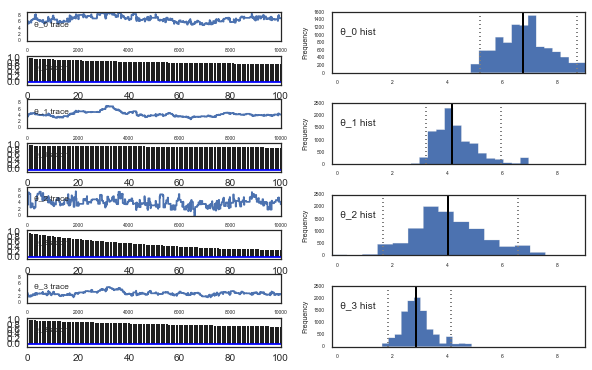

In [120]:
pm.Matplot.plot(θ)

Plotting σ_0
Plotting σ_1
Plotting σ_2
Plotting σ_3
Plotting σ_4


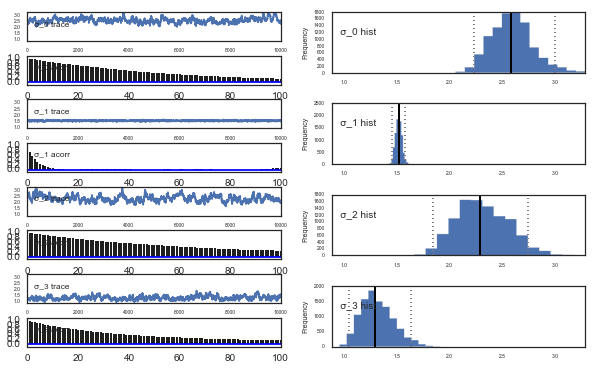

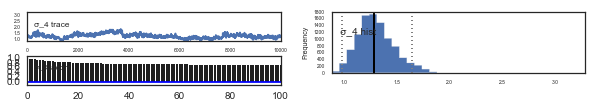

In [121]:
pm.Matplot.plot(σ)

In [122]:
σ.summary()


σ:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	2.591            0.209            0.014            [ 2.221  3.017]
	1.518            0.03             0.001            [ 1.459  1.576]
	2.345            0.27             0.02             [ 1.843  2.857]
	1.323            0.15             0.008            [ 1.06   1.618]
	1.32             0.179            0.016            [ 0.999  1.671]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	2.234            2.434           2.58           2.724         3.046
	1.46             1.497           1.518          1.538         1.578
	1.865            2.149           2.327          2.531         2.909
	1.072            1.212           1.306          1.422         1.65
	1.016            1.189           1.301          1.44          1.696
	


In [123]:
θ.summary()


θ:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	6.91             0.906            0.08             [ 5.243  8.671]
	4.432            0.737            0.071            [ 3.14   5.721]
	4.144            1.242            0.088            [ 1.659  6.582]
	3.043            0.559            0.05             [ 1.919  4.118]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	5.283            6.244           6.89           7.527         8.773
	3.256            3.915           4.315          4.903         5.971
	1.741            3.441           4.084          4.919         6.801
	2.009            2.68            2.997          3.341         4.515
	


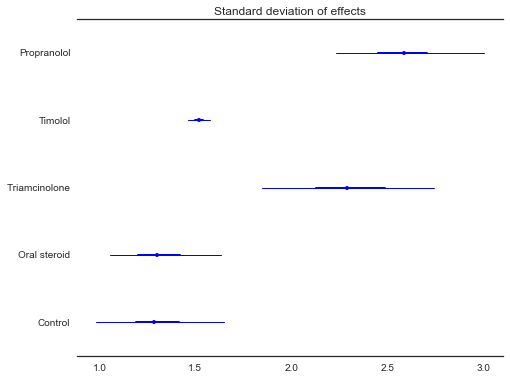

In [175]:
sigma_labels = ['Propranolol', 
               'Timolol', 
               'Triamcinolone ', 
               'Oral steroid',
               'Control']

pm.Matplot.summary_plot(σ, custom_labels=sigma_labels, 
                        vline_pos=-1, main='Standard deviation of effects', chain=1)

In [172]:
expected_clearance.summary()


expected_clearance:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.035            0.027            0.003            [ 0.004  0.1  ]
	0.338            0.273            0.014            [ 0.001  0.866]
	0.96             0.025            0.002            [ 0.91   0.993]
	0.688            0.118            0.011            [ 0.46   0.868]
	0.608            0.223            0.014            [ 0.195  0.975]
	0.379            0.138            0.013            [ 0.156  0.659]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.005            0.018           0.028          0.041         0.119
	0.011            0.101           0.262          0.536         0.923
	0.895            0.949           0.966          0.976         0.988
	0.438            0.604           0.703          0.786       

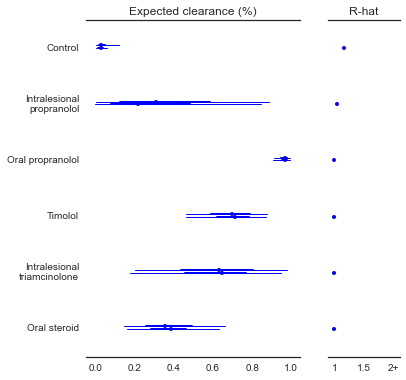

In [177]:
pm.Matplot.summary_plot(expected_clearance, custom_labels=rate_labels, 
                        main='Expected clearance (%)', vline_pos=-1)

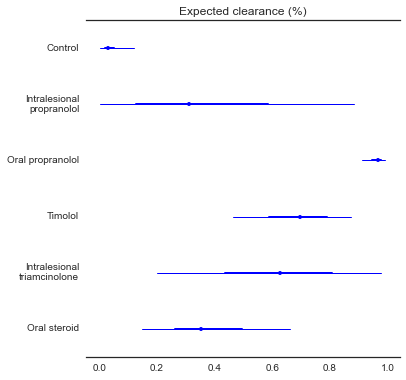

In [178]:
pm.Matplot.summary_plot(expected_clearance, custom_labels=rate_labels, 
                        main='Expected clearance (%)', vline_pos=-1, chain=1)

In [179]:
μ.summary()


μ:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-3.584           0.769            0.074            [-5.286 -2.095]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-5.226           -4.011          -3.544         -3.164        -2.002
	


In [180]:
σ.summary()


σ:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	2.591            0.209            0.014            [ 2.221  3.017]
	1.518            0.03             0.001            [ 1.459  1.576]
	2.345            0.27             0.02             [ 1.843  2.857]
	1.323            0.15             0.008            [ 1.06   1.618]
	1.32             0.179            0.016            [ 0.999  1.671]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	2.234            2.434           2.58           2.724         3.046
	1.46             1.497           1.518          1.538         1.578
	1.865            2.149           2.327          2.531         2.909
	1.072            1.212           1.306          1.422         1.65
	1.016            1.189           1.301          1.44          1.696
	


In [181]:
means = (μ.trace() + θ.trace().T).T

In [182]:
sds = σ.trace()[:, :-1]

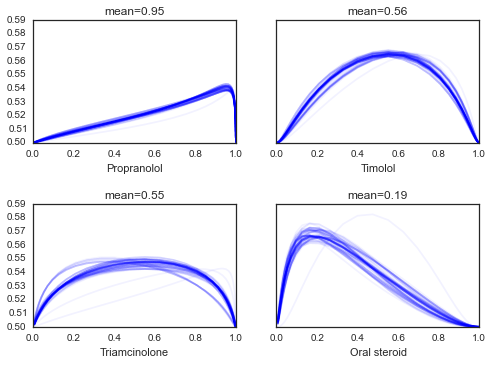

In [136]:
import matplotlib.pyplot as plt
from pymc import invlogit
from scipy.stats import norm

labels = ['Propranolol', 
               'Timolol', 
               'Triamcinolone', 
               'Oral steroid']

fig, axes = plt.subplots(2,2, sharey=True)

n = 100
xvals = np.linspace(-5, 10)

for j,ax in enumerate(np.ravel(axes)):
    m = np.empty(n)
    for i in range(n):
        dist = norm(means[-i,j], sds[-i,j])
        m[i] = invlogit(dist.mean())
        ax.plot(invlogit(xvals), invlogit(dist.pdf(xvals)), 'b-', alpha=0.05)
    ax.set_xlabel(labels[j])
    ax.set_title('mean=%s' % np.mean(m).round(2))

## Surface Under the Cumulative RAnking curve (SUCRA)

Use posterior probabilities for each treatment to be among the n-best options (cumulative probabilities)

In [151]:
# Calculate ranks for treatments from expected clearance traces
clearance_ranks = np.argsort(expected_clearance.trace()) + 1
samples, ranks = clearance_ranks.shape

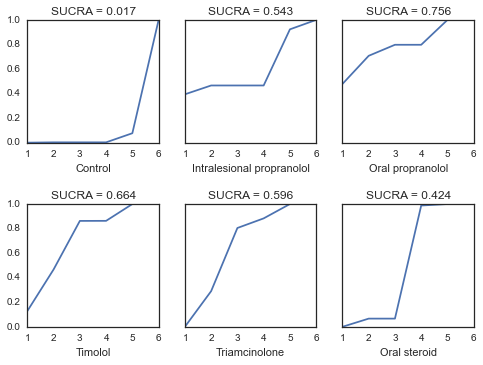

In [169]:
fig, axes = plt.subplots(2, 3, sharey=True)

for i, treat in enumerate(rate_labels):
    ax = axes.ravel()[i]
    ax.set_xlabel(treat)
    
    # Pull out ranks for treatment
    rank = clearance_ranks[:, i]
    # Calculate cumulative probabilities
    cumulative_probs = [(rank>=(j+1)).mean() for j in range(ranks)][::-1]
    # Calculate SUCRA
    sucra = sum(cumulative_probs[:-1])/(ranks-1)
    
    ax.set_title('SUCRA = %s' % np.round(sucra, 3))
    ax.plot(np.arange(ranks)+1, cumulative_probs)